# Ensemble Learning and Random Forests

Suppose you pose a complex question to thousands of random people, then aggregate their  answers.  In  many  cases  you  will  find  that  this  aggregated  answer  is  better  than an expert’s answer. This is called the wisdom of the crowd. Similarly, if you aggregate the  predictions  of  a  group  of  predictors  (such  as  classifiers  or  regressors),  you  will often  get  better  predictions  than  with  the  best  individual  predictor.  A  group  of  predictors is called an ensemble; thus, this technique is called Ensemble Learning, and an Ensemble Learning algorithm is called an Ensemble method. As an example of an Ensemble method, you can train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, you obtain  the  predictions  of  all  the  individual  trees,  then  predict  the  class  that  gets  the most votes. Such an ensemble of Decision Trees is called  a  Random  Forest,  and  despite  its  simplicity,  this  is  one  of  the  most  powerfulMachine Learning algorithms available today. You  will  often  use  Ensemble  methods  near  the  end  of  aproject, once you have already built a few good predictors, to combine them into an even  better  predictor.  In  fact,  the  winning  solutions  in  Machine  Learning  competitions  often  involve  several  Ensemble  methods  (most  famously  in  the  Netflix  Prize competition). In  this  chapter  we  will  discuss  the  most  popular  Ensemble  methods,  including  bagging, boosting, and stacking. We will also explore Random Forests.

In [5]:
#Common setup and imports

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np

# to make this notebook's output stable across runs
np.random.seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Voting Classifiers

Suppose  you  have  trained  a  few  classifiers,  each  one  achieving  about  80%  accuracy. You  may  have  a  Logistic  Regression  classifier,  an  SVM  classifier,  a  Random  Forestclassifier, a K-Nearest Neighbors classifier, and perhaps a few more as in figure below.

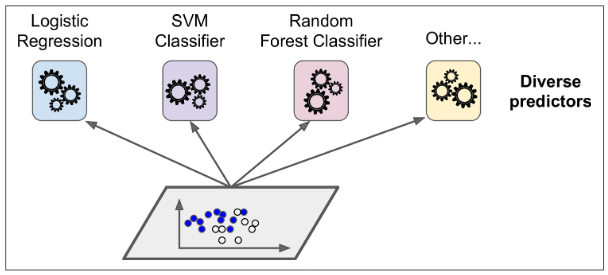

A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a hard voting classifier (fig below).

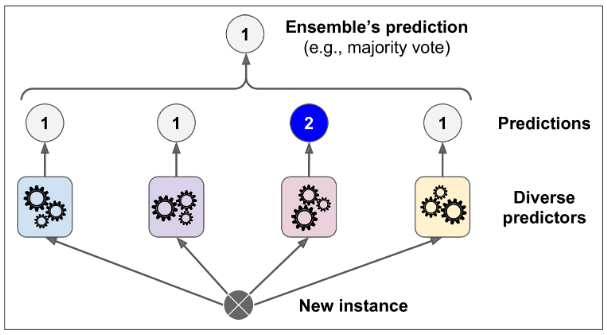

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a weak learner (meaning  it  does  only  slightly  better  than  random  guessing),  the  ensemble  can  still  be  a strong  learner  (achieving  high  accuracy),  provided  there  are  a  sufficient  number  of weak learners and they are sufficiently diverse.

How is this possible? The following analogy can help shed some light on this mystery. Suppose  you  have  a  slightly  biased  coin  that  has  a  51%  chance  of  coming  up  heads and  49%  chance  of  coming  up  tails.  If  you  toss  it  1,000  times,  you  will  generally  get more  or  less  510  heads  and  490  tails,  and  hence  a  majority  of  heads.  If  you  do  the math,  you  will  find  that  the  probability  of  obtaining  a  majority  of  heads  after  1,000 tosses  is  close  to  75%.  The  more  you  toss  the  coin,  the  higher  the  probability  (e.g. ,with  10,000  tosses,  the  probability  climbs  over  97%).  This  is  due  to  the  law  of  large numbers: as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads (51%). Figure below shows 10 series of biased coin tosses. You can see that as the number of tosses increases, the ratio of heads approaches 51%. Eventually all 10 series end up so close to 51% that they are consistently above 50%.

In [9]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1) 

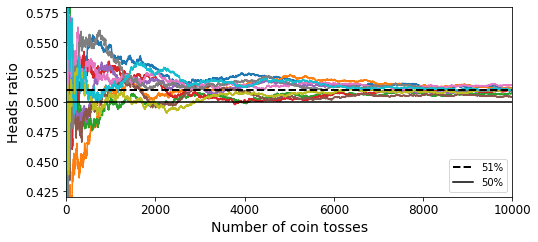

In [8]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])

plt.show()

Similarly, suppose you build an ensemble containing 1,000 classifiers that are individually  correct  only  51%  of  the  time  (barely  better  than  random  guessing).  If  you  predict  the  majority  voted  class,  you  can  hope  for  up  to  75%  accuracy!  However,  this  is only  true  if  all  classifiers  are  perfectly  independent,  making  uncorrelated  errors, which is clearly not the case because they are trained on the same data. They are likelyto make the same types of errors, so there will be many majority votes for the wrong class, reducing the ensemble’s accuracy.

Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.

The following code creates and trains a voting classifier in Scikit-Learn, composed of three  diverse  classifiers  (the  training  set  is  the  moons  dataset):

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [12]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

Let's check the accuracy of each classifier along with :

In [13]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


The  voting  classifier  slightly  outperforms  all  the  individual classifiers. If  all  classifiers  are  able  to  estimate  class  probabilities  (i.e.,  they  all  have  a  predict_proba()  method),  then  you  can  tell  Scikit-Learn  to  predict  the  class  with  the highest class probability, averaged over all the individual classifiers. This is called softvoting.  It  often  achieves  higher  performance  than  hard  voting  because  it  gives  more weight  to  highly  confident  votes.  All  you  need  to  do  is  replace  voting="hard"  with voting="soft"  and  ensure  that  all  classifiers  can  estimate  class  probabilities.  This  is not  the  case  for  the  SVC  class  by  default,  so  you  need  to  set  its  probability  hyper‐parameter to True (this will make the SVC class use cross-validation to estimate class probabilities,  slowing  down  training,  and  it  will  add  a  predict_proba()  method).  If you modify the preceding code to use soft voting, you will find that the voting classifier achieves over 91.2% accuracy!

## Bagging and Pasting

One way to get a diverse set of classifiers is to use very different training algorithms, as  just  discussed.  Another  approach  is  to  use  the  same  training  algorithm  for  every predictor and train them on different random subsets of the training set. When sampling  is  performed  with  replacement,  this  method  is  called  bagging (short  for  boot‐strap  aggregating).  When  sampling  is  performed  without  replacement,  it  is  called pasting.

In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled  several  times  for  the  same  predictor.  This  sampling  and  training  process  is represented in Figure below.

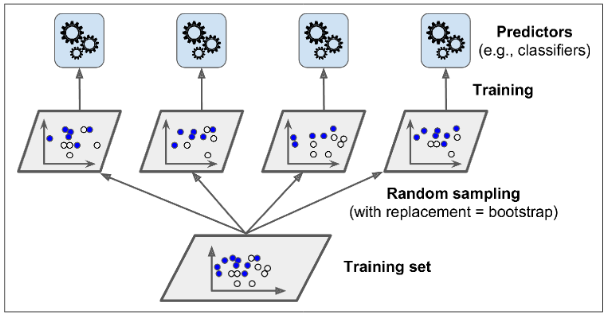

Once  all  predictors  are  trained,  the  ensemble  can  make  a  prediction  for  a  new instance  by  simply  aggregating  the  predictions  of  all  predictors.  The  aggregation function is typically the statistical mode (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression. Each individual predictor  has  a  higher  bias  than  if  it  were  trained  on  the  original  training  set,  but aggregation  reduces  both  bias  and  variance.  Generally,  the  net  result  is  that  the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.

As  you  can  see  in  Figure  above,  predictors  can  all  be  trained  in  parallel,  via  different CPU  cores  or  even  different  servers.  Similarly,  predictions  can  be  made  in  parallel. This is one of the reasons bagging and pasting are such popular methods: they scale very well.

## Baggin and Pasting in Scikit-Learn

Scikit-Learn offers a simple API for both bagging and pasting with the BaggingClassifier  class  (or  BaggingRegressor  for  regression).  The  following  code  trains  anensemble  of  500  Decision  Tree  classifiers:  each  is  trained  on  100  training  instances randomly sampled from the training set with replacement (this is an example of bagging,  but  if  you  want  to  use  pasting  instead,  just  set  bootstrap=False).  The  n_jobs parameter tells Scikit-Learn the number of CPU cores to use for training and predictions (-1 tells Scikit-Learn to use all available cores):

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

The BaggingClassifier    automatically    performs    soft    voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a predict_proba() method), which is the case with Decision Tree classifiers.

Figure below compares  the  decision  boundary  of  a  single  Decision  Tree  with  the  decision  boundary  of  a  bagging  ensemble  of  500  trees  (from  the  preceding  code),  both trained  on  the  moons  dataset.  As  you  can  see,  the  ensemble’s  predictions  will  likely generalize much better than the single Decision Tree’s predictions: the ensemble has acomparable bias but a smaller variance (it makes roughly the same number of errorson the training set, but the decision boundary is less irregular).

max_samples can alternatively be set to a float between 0.0 and 1.0, in which case the max number of instances to sample is equal to the size of the training set times max_samples.

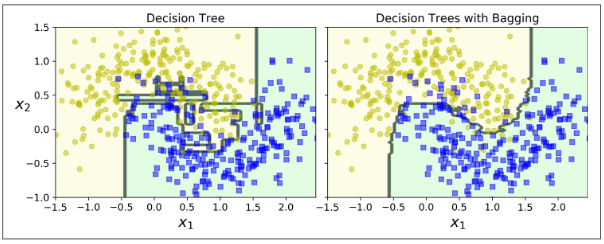

Bootstrapping  introduces  a  bit  more  diversity  in  the  subsets  that  each  predictor  is trained on, so bagging ends up with a slightly higher bias than pasting; but the extra diversity also means that the predictors end up being less correlated, so the ensemble’s variance  is  reduced.  Overall,  bagging  often  results  in  better  models,  which  explain swhy  it  is  generally  preferred.  However,  if  you  have  spare  time  and  CPU  power,  you can use cross-validation to evaluate both bagging and pasting and select the one that works best.

## Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor, while  others  may  not  be  sampled  at  all.  By  default  a  BaggingClassifier  samples  m training  instances  with  replacement  (bootstrap=True),  where  m  is  the  size  of  the training set. This means that only about 63% of the training instances are sampled on average for each predictor. The remaining 37% of the training instances that are not sampled  are  called  out-of-bag  (oob)  instances.  Note  that  they  are  not  the  same  37% for all predictors. Since a predictor never sees the oob instances during training, it can be evaluated on these  instances,  without  the  need  for  a  separate  validation  set.  You  can  evaluate  the ensemble itself by averaging out the oob evaluations of each predictor. In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to request an automatic oob evaluation after training. The following code demonstratesthis. The resulting evaluation score is available through the oob_score_ variable:

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)

bag_clf.fit(X_train, y_train) # needed code completion
bag_clf.oob_score_

According  to  this  oob  evaluation,  this  BaggingClassifier  is  likely  to  achieve  about 90.1% accuracy on the test set. Let’s verify this:

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

We get 91.2% accuracy on the test set—close enough! The  oob  decision  function  for  each  training  instance  is  also  available  through  the oob_decision_function_  variable.  In  this  case  (since  the  base  estimator  has  a  predict_proba() method), the decision function returns the class probabilities for each training  instance.  For  example,  the  oob  evaluation  estimates  that  the  first  training instance  has  a  68.25%  probability  of  belonging  to  the  positive  class  (and  31.75%  of belonging to the negative class):

In [ ]:
bag_clf.oob_decision_function_

## Random Patches and Random Subspaces

The  BaggingClassifier  class  supports  sampling  the  features  as  well.  Sampling  is controlled  by  two  hyperparameters:  max_features  and  bootstrap_features.  They work the same way as max_samples and bootstrap, but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of the input features. This  technique  is  particularly  useful  when  you  are  dealing  with  high-dimensional inputs  (such  as  images).  Sampling  both  training  instances  and  features  is  called  the Random Patches method. Keeping all training instances (by setting bootstrap=False and max_samples=1.0) but sampling features (by srtting bootstrap_features to True and/or max_features to a value smaller then 1.0) is called the Random Subspaces method.

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

## Random Forests

As we have discussed, a Random Forest is an ensemble of Decision Trees, generally trained  via  the  bagging  method  (or  sometimes  pasting),  typically  with  max_samples set to the size of the training set. Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, you can instead use the RandomForestClassifierclass, which is more convenient and optimized for Decision Trees (similarly, there is a  RandomForestRegressor  class  for  regression  tasks).  The  following  code  uses  allavailable  CPU  cores  to  train  a  Random  Forest  classifier  with  500  trees  (each  limited to maximum 16 nodes).

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(x_train, y_train) # not generated datasaet

y_pred_rf = rnd_clf.predict(X_test)

With  a  few  exceptions,  a  RandomForestClassifier  has  all  the  hyperparameters  of  a DecisionTreeClassifier  (to  control  how  trees  are  grown),  plus  all  the  hyperparameters of a BaggingClassifier to control the ensemble itself. The  Random  Forest  algorithm  introduces  extra  randomness  when  growing  trees; instead of searching for the very best feature when splitting a node, it searches  for  the  best  feature  among  a  random  subset  of  features.  The  algorithm results  in  greater  tree  diversity,  which  (again)  trades  a  higher  bias  for  a  lower  variance,  generally  yielding  an  overall  better  model.  The  following  BaggingClassifieris roughly equivalent to the previous RandomForestClassifier.

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

## Extra-Trees

When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting (as discussed earlier). It is possible to make trees even more random by also using random thres holds for each feature rather than searching for the best possible thresholds (like regular Decision Trees do). A  forest  of  such  extremely  random  trees  is  called  an  Extremely  Randomized  Tree sensemble (or Extra-Trees for short). Once again, this technique trades more bias for a lower variance. It also makes Extra-Trees much faster to train than regular RandomForests,  because  finding  the  best  possible  threshold  for  each  feature  at  every  node  is one of the most time consuming tasks of growing a tree. You  can  create  an  Extra-Trees  classifier  using  Scikit-Learn’s  ExtraTreesClassifierclass.  Its  API  is  identical  to  the  RandomForestClassifier  class.  Similarly,  the  ExtraTreesRegressor class has the same API as the RandomForestRegressor class.


## Feature Importance

Yet another great quality of Random Forests is that they make it easy to measure the relative  importance  of  each  feature.  Scikit-Learn  measures  a  feature’s  importance  by looking at how much the tree nodes that use that feature reduce impurity on average (across  all  trees  in  the  forest).  More  precisely,  it  is  a  weighted  average,  where  each node’s  weight  is  equal  to  the  number  of  training  samples  that  are  associated  with  it. Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. You can access the result  using  the  feature_importances_  variable.  For  example,  the  following  code trains  a  RandomForestClassifier  on  the  iris  dataset and outputs  each  feature’s  importance.  It  seems  that  the  most  important  features  are  the petal  length  and  width,  while  sepal  length  and  width  are  rather  unimportant in comparison.

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

## Boosting 

Boosting  (originally  called  hypothesis  boosting)  refers  to  any  Ensemble  method  thatcan  combine  several  weak  learners  into  a  strong  learner.  The  general  idea  of  mostboosting methods is to train predictors sequentially, each trying to correct its prede‐cessor.  There  are  many  boosting  methods  available,  but  by  far  the  most  popular  are AdaBoost (short  for  Adaptive  Boosting)  and  Gradient  Boosting.  Let’s  start  with  Ada‐Boost.

## AdaBoost

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor under fitted. This results in new predictors  focusing  more  and  more  on  the  hard  cases.  This  is  the  technique  used  by AdaBoost. For  example,  when  training  an  AdaBoost  classifier,  the  algorithm  first  trains  a  base classifier (such as a Decision Tree) and uses it to make predictions on the training set. The  algorithm  then  increases  the  relative  weight  of  misclassified  training  instances. Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on (This is just for illustrative purposes. SVMs are generally not good base predictors for AdaBoost; they are slowand tend to be unstable with it).

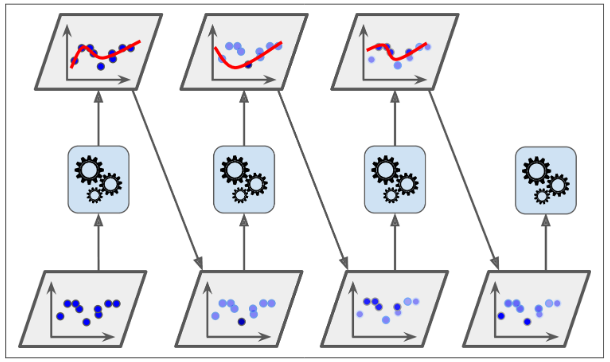

Figure below shows  the  decision  boundaries  of  five  consecutive  predictors  on  the moons dataset (in this example, each predictor is a highly regularized SVM classifier with an RBF kernel). The first classifier gets many instances wrong, so their weights get boosted. The second classifier therefore does a better job on these instances, and so  on.  The  plot  on  the  right  represents  the  same  sequence  of  predictors,  except  that the learning rate is halved (i.e., the misclassified instance weights are boosted half as much at every iteration). As you can see, this sequential learning technique has some similarities with Gradient Descent, except that instead of tweaking a single predictor’s parameters  to  minimize  a  cost  function,  AdaBoost  adds  predictors  to  the  ensemble, gradually making it better.

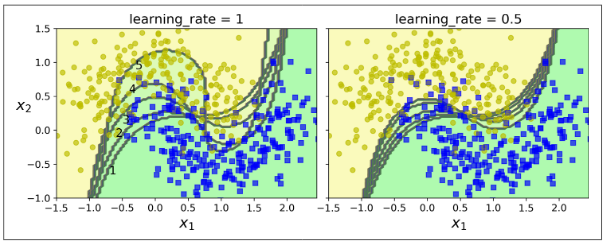

Once all predictors are trained, the ensemble makes predictions very much like bagging  or  pasting,  except  that  predictors  have  different  weights  depending  on  their overall accuracy on the weighted training set.

There is one important drawback to this sequential learning technique: it cannot be parallelized (or only partially), since each predictor  can  only  be  trained  after  the  previous  predictor  has  been trained  and  evaluated.  As  a  result,  it  does  not  scale  as  well  as  bagging or pasting.

Let’s take a closer look at the AdaBoost algorithm. Each instance weight w<sup>(i)</sup> is initially set  to  1/m.  A  first  predictor  is  trained,  and  its  weighted  error  rate  r1  is  computed  onthe training set;

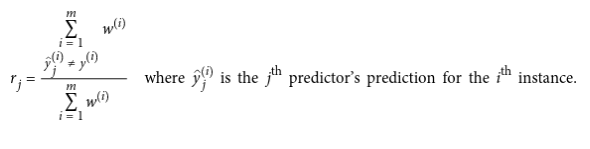

The predictor’s weight α<sub>j</sub> is then computed using Equation below, where η is the learning  rate  hyperparameter  (defaults  to  1).  The  more  accurate  the  predictor  is,  the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero.  However,  if  it  is  most  often  wrong  (i.e.,  less  accurate  than  random  guessing),then its weight will be negative.

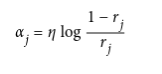

Next,  the  AdaBoost  algorithm  updates  the  instance  weights,  using  Equation  below, which boosts the weights of the misclassified instances.

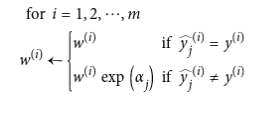

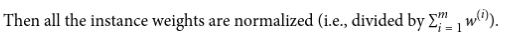

Finally, a new predictor is trained using the updated weights, and the whole process is repeated  (the  new  predictor’s  weight  is  computed,  the  instance  weights  are  updated, then  another  predictor  is  trained,  and  so  on).  The  algorithm  stops  when  the  desired number of predictors is reached, or when a perfect predictor is found. To make predictions, AdaBoost simply computes the predictions of all the predictors and  weighs  them  using  the  predictor  weights  α<sub>j</sub>.  The  predicted  class  is  the  one  that receives the majority of weighted votes.
(The original AdaBoost algorithm does not use a learning rate hyperparameter)

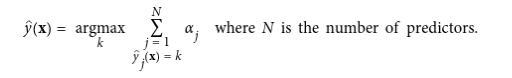

Scikit-Learn uses a multiclass version of AdaBoost called SAMME (which stands for Stagewise Additive Modeling using a Multiclass Exponential loss function). When there are just two classes, SAMME is equivalent to AdaBoost. If the predictors can estimate class probabilities (i.e., if they have a predict_proba() method), Scikit-Learn can usea variant of SAMME called SAMME.R (the R stands for “Real”), which relies on class probabilities rather than predictions and generally performs better. The following code trains an AdaBoost classifier based on 200 Decision Stumps using Scikit-Learn’s  AdaBoostClassifier  class  (as  you  might  expect,  there  is  also  an  AdaBoostRegressor  class).  A  Decision  Stump  is  a  Decision  Tree  with  max_depth=1 in other  words,  a  tree  composed  of  a  single  decision  node  plus  two  leaf  nodes.  This  is the default base estimator for the AdaBoostClassifier class.

In [ ]:
# code  not completed correction needed
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5
)

ada_clf.fit(X_train, y_train)

If  your  AdaBoost  ensemble  is  overfitting  the  training  set,  you  cantry  reducing  the  number  of  estimators  or  more  strongly  regularizing the base estimator.

## Gradient Boosting

Another  very  popular  boosting  algorithm  is  Gradient  Boosting.  Just  like  AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor. Let’s go through a simple regression example, using Decision Trees as the base predictors  (of  course,  Gradient  Boosting  also  works  great  with  regression  tasks).  This  is called Gradient Tree Boosting, or Gradient Boosted Regression Trees (GBRT). First, let’s fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic training set).

In [ ]:
# incomplete code
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

Next, we’ll train a second DecisionTreeRegressor on the residual errors made by thefirst predictor:

In [ ]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

Then we train a third regressor on the residual errors made by the second predictor:

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

Now  we  have  an  ensemble  containing  three  trees.  It  can  make  predictions  on  a  new instance simply by adding up the predictions of all the trees:

In [ ]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

Figure below represents  the  predictions  of  these  three  trees  in  the  left  column,  and  the ensemble’s predictions in the right column. In the first row, the ensemble has just onetree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the  second  tree.  You  can  see  that  the  ensemble’s  predictions  gradually  get  better  astrees are added to the ensemble.A simpler way to train GBRT ensembles is to use Scikit-Learn’s GradientBoostingRegressor class. Much like the RandomForestRegressor class, it has hyperparameters to control the growth of Decision Trees (e.g., max_depth, min_samples_leaf), as well as hyperparameters  to  control  the  ensemble  training,  such  as  the  number  of  trees(n_estimators). The following code creates the same ensemble as the previous one:

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

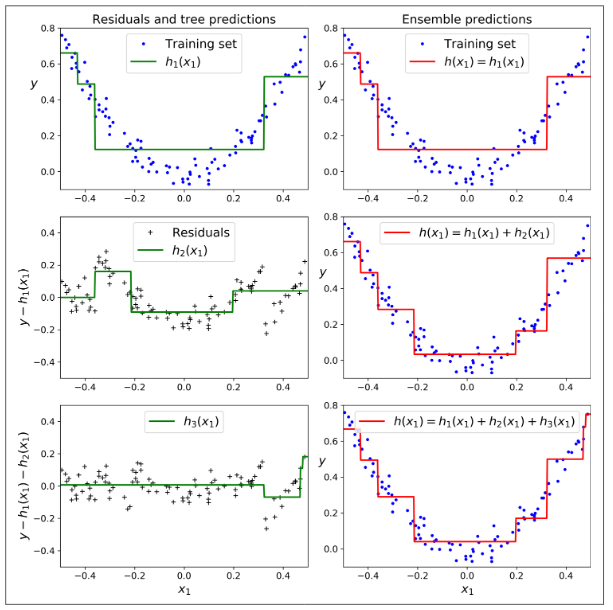

In this depiction of Gradient Boosting, the first predictor (top left) is trained normally, then each consecutive predictor (middle left and lower left) is trained on the previous predictor’s residuals; the right column shows the resulting ensemble’s predictions. The learning_rate hyperparameter scales the contribution of each tree. If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique  called  shrinkage.  Figure  below  shows  two  GBRT  ensembles  trained  with  a  low learning  rate:  the  one  on  the  left  does  not  have  enough  trees  to  fit  the  training  set, while the one on the right has too many trees and overfits the training set.

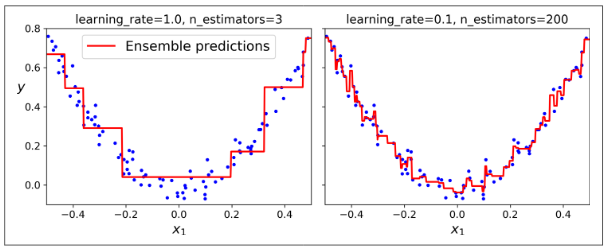

In  order  to  find  the  optimal  number  of  trees,  you  can  use  early  stopping.  A  simple  way  to  implement  this  is  to  use  the  staged_predict()  method:  it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.). The following code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal  number  of  trees,  and  finally  trains  another  GBRT  ensemble  using  the  optimalnumber of trees:

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
         for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimarots = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(X_train, y_train)

The validation errors are represented on the left of Figure below, and the best model’s predictions are represented on the right.

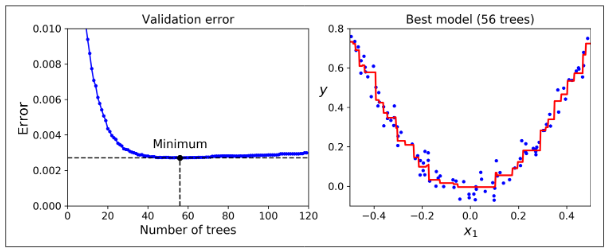


It  is  also  possible  to  implement  early  stopping  by  actually  stopping  training  early (instead  of  training  a  large  number  of  trees  first  and  then  looking  back  to  find  the optimal  number).  You  can  do  so  by  setting  warm_start=True,  which  makes  Scikit-Learn  keep  existing  trees  when  the  fit()  method  is  called,  allowing  incremental training.  The  following  code  stops  training  when  the  validation  error  does  not improve for five iterations in a row.

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=2)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else 
    error_going_up += 1
    if error_going_up ==5:
        break # early Stopping

The  GradientBoostingRegressor  class  also  supports  a  subsample  hyperparameter, which specifies the fraction of training instances to be used for training each tree. For example, if subsample=0.25, then each tree is trained on 25% of the training instances,  selected  randomly.  As  you  can  probably  guess  by  now,  this  technique  trades  a higher bias for a lower variance. It also speeds up training considerably. This is called Stochastic Gradient Boosting.

It  is  possible  to  use  Gradient  Boosting  with  other  cost  functions. This  is  controlled  by  the  loss  hyperparameter.

It  is worth noting that an optimized implementation of Gradient Boosting is availablein the popular Python library XGBoost, which stands for Extreme Gradient Boosting. This package was initially developed by Tianqi Chen as part of the Distributed (Deep)Machine  Learning  Community  (DMLC),  and  it  aims  to  be  extremely  fast,  scalable,and  portable.  In  fact,  XGBoost  is  often  an  important  component  of  the  winningentries in ML competitions. XGBoost’s API is quite similar to Scikit-Learn’s:

In [ ]:
import xgboost 

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(x_val)

XGBoost  also  offers  several  nice  features,  such  as  automatically  taking  care  of  earlystopping:

In [ ]:
# incomplete

xgb_reg.fit(X_train, y_train,
           eval_set=[(x_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

## Stacking

Stacking is based on a simple idea: instead of using trivial functions(such  as  hard  voting)  to  aggregate  the  predictions  of  all  predictors  in  an  ensemble, why  don’t  we  train  a  model  to  perform  this  aggregation?  Figure  below  shows  such  an ensemble  performing  a  regression  task  on  a  new  instance.  Each  of  the  bottom  threepredictors  predicts  a  different  value  (3.1,  2.7,  and  2.9),  and  then  the  final  predictor(called  a  blender,  or  a  meta  learner)  takes  these  predictions  as  inputs  and  makes  the final prediction (3.0).

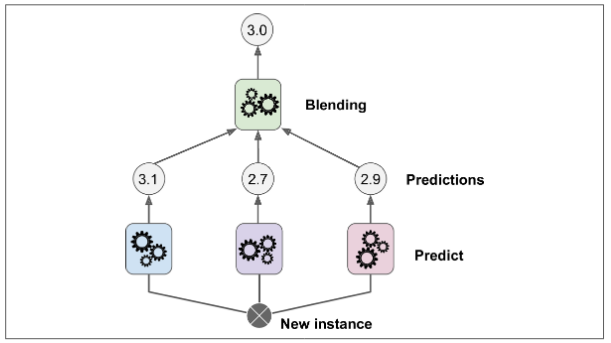

To  train  the  blender,  a  common  approach  is  to  use  a  hold-out  set.  Let’s  see  how  it works. First, the training set is split into two subsets. The first subset is used to train the predictors in the first layer (figure  below).

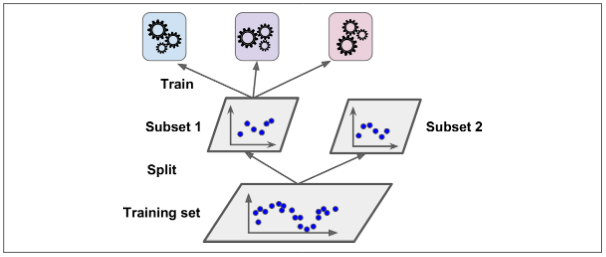

Next,  the  first  layer’s  predictors  are  used  to  make  predictions  on  the  second  (held-out) set (see Figure below). This ensures that the predictions are “clean,” since the predictors  never  saw  these  instances  during  training.  For  each  instance  in  the  hold-out set, there are three predicted values. We can create a new training set using these predicted  values  as  input  features  (which  makes  this  new  training  set  3D),  and  keeping the  target  values.  The  blender  is  trained  on  this  new  training  set,  so  it  learns  to  predict the target value, given the first layer’s predictions.

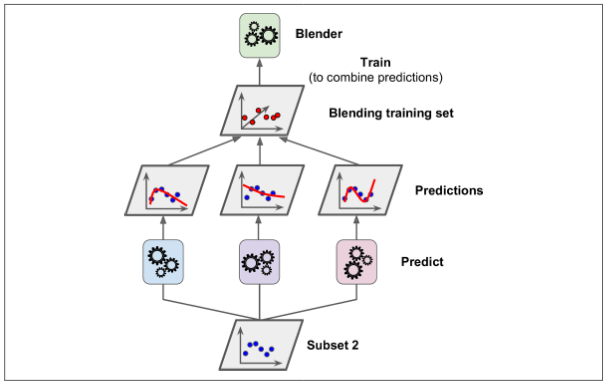

It is actually possible to train several different blenders this way (e.g., one using Linear  Regression,  another  using  Random  Forest  Regression),  to  get  a  whole  layer  of blenders. The trick is to split the training set into three subsets: the first one is used to train the first layer, the second one is used to create the training set used to train the second  layer  (using  predictions  made  by  the  predictors  of  the  first  layer),  and  the third  one  is  used  to  create  the  training  set  to  train  the  third  layer  (using  predictions made by the predictors of the second layer). Once this is done, we can make a prediction  for  a  new  instance  by  going  through  each  layer  sequentially,  as  shown  in Figure below.

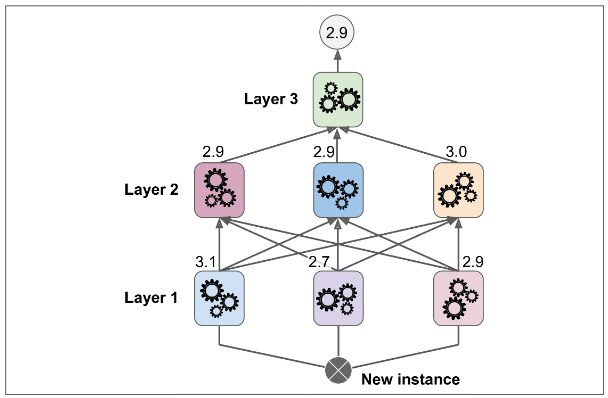

Unfortunately,  Scikit-Learn  does  not  support  stacking  directly,  but  it  is  not  too  hard to roll out your own implementation. Alternatively, you can use an open source implementation such as DESlib.